# Bridge Data Cleaning

#### Outline of the notebook
This notebook for the cleaning of the road data has the following outline: <br>
1. Import python packages, import the data, get insight in the data
1. Get insight in the data
2. Filter for datapoints that are not in Bangladesh
3. Fix swapped lat-lon values
4. Check for road present in road dataset
5. Correct bridges that aren't on the correct road location

At every step, there is a description of the methodology as well as illustrations of the cleanings. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

from shapely.geometry import Point
import pyproj
from shapely.geometry import Point, LineString
from tqdm import tqdm


## `1. Import python packages, import the data, get insight in the data`

In [2]:
# Import the bridge data
df_brd_original = pd.read_excel('data/BMMS_overview.xlsx')
display(df_brd_original.head(5))

# Import the road data
df_rd = pd.read_csv('data/_roads_cleaned.tsv', sep='\t', low_memory=False)
display(df_rd.head(5))

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.8,19.5,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702889,90.450389,bcs1
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,35.4,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.693611,90.478833,bcs1
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.704583,90.518833,road_precise
3,N1,10.880,Box Culvert,LRP010b,NOYAPARA CULVERT,6.30,A,112531,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.88,12.2,1992.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.699833,90.530722,bcs1
4,N1,10.897,Box Culvert,LRP010c,ADUPUR CULVERT,6.30,A,112532,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.897,12.2,1984.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.699667,90.530722,bcs1


,road,lrp1,lat1,lon1,lrp2,lat2,lon2,lrp3,lat3,lon3,...,lon1345,lrp1346,lat1346,lon1346,lrp1347,lat1347,lon1347,lrp1348,lat1348,lon1348
0,N1,LRPS,23.706028,90.443333,LRPSa,23.702917,90.450417,LRPSb,23.702778,90.450472,...,92.29825,LRP466c,20.864667,92.298194,LRP467,20.862972,92.298083,LRPE,20.862917,92.298083
1,N101,LRPS,23.454139,91.212861,LRPSa,23.461889,91.212000,LRP001,23.462944,91.211806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N102,LRPS,23.478972,91.118194,LRPSa,23.481583,91.116777,LRPSb,23.486666,91.113361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N103,LRPS,23.957028,91.115528,LRP001,23.961917,91.113611,LRP001a,23.967666,91.111889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N104,LRPS,23.009667,91.399416,LRPSa,23.009278,91.395250,LRP001,23.009306,91.389805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Transform the road DataFrame to long format

def extract_lrps(df_rd):
    all_roads = []
    
    for i in range(len(df_rd)):  # Loop through all rows (roads)
        row = df_rd.iloc[i]

        # print(row.iloc[0])

        # Extract every third value for LRP, LAT, and LON
        df_rd_long = pd.DataFrame({
            'road': row.iloc[0],
            'LRP': row.iloc[1::3].values,
            'LAT': row.iloc[2::3].astype(float).values,
            'LON': row.iloc[3::3].astype(float).values
        })
        
        # df_rd_N6['Road_ID'] = i  # Add road number 
        all_roads.append(df_rd_long)  # Append results

    return pd.concat(all_roads, ignore_index=True)  # Merge all road data

df_rd_long = extract_lrps(df_rd)

# Drop rows with missing values for faster processing
df_rd_long = df_rd_long.dropna(subset=['LRP', 'LAT', 'LON'])


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


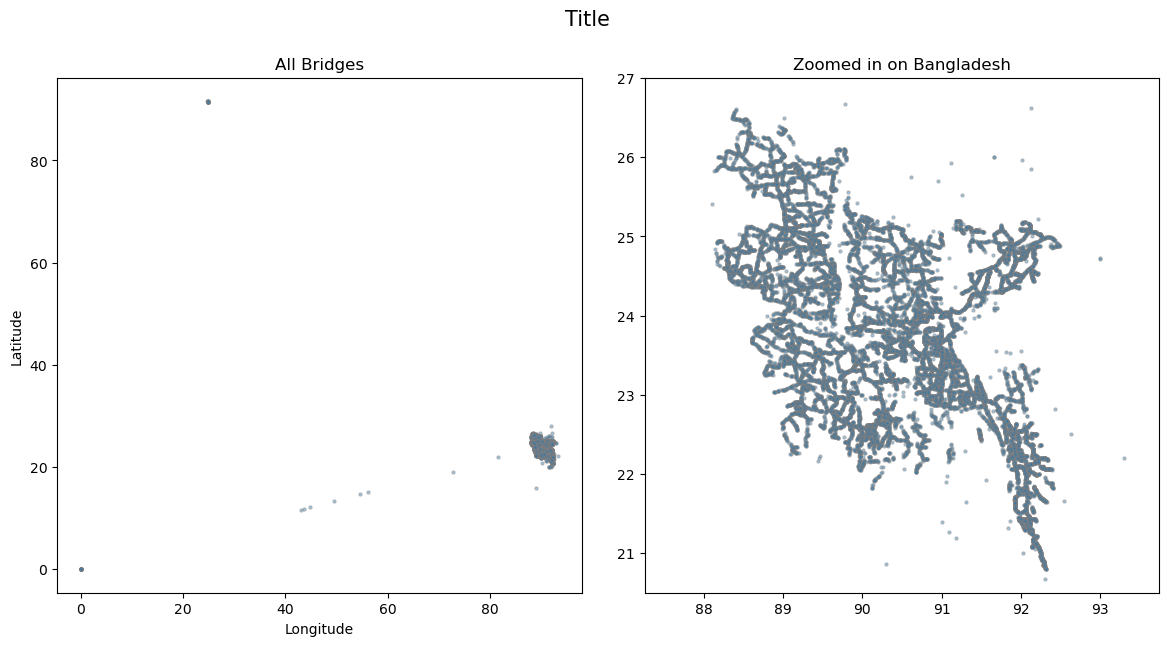

In [4]:
# Create plot function for the bridges
def plot_bridges(df, title):
    # Create a figure and axis
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Create a scatter plot for all the bridges
    ax[0].scatter(df['lon'], df['lat'], s=5, edgecolor='grey', facecolor=None, alpha=0.4)

    # Create a scatter plot for the bridges, while zooming in on Bangladesh
    ax[1].scatter(df['lon'], df['lat'], s=5, edgecolor='grey', facecolor=None, alpha=0.4)
    ax[1].set_xlim(88, 93)
    ax[1].set_ylim(20.5, 27)

    # Set the title and labels
    ax[0].set_title('All Bridges')
    ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[1].set_title('Zoomed in on Bangladesh')
    
    # Set the aspect of the plot to be equal
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    ax[1].set_box_aspect(1)

    fig.suptitle('Title', fontsize=15, y=1.03)
    fig.tight_layout()
    plt.savefig(title + '.png', dpi=400)
    plt.show()

# Plot the bridges
plot_bridges(df_brd_original, 'Initial Bridge locations in the BMMS dataset')


## `2. Filter datapoints that are not located in bangladesh`

I use a buffer, as the shapefile is not that precise

C:\Users\groen\AppData\Local\Temp\ipykernel_344\1586597025.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bridges_outside = gdf_bridges[~gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]
C:\Users\groen\AppData\Local\Temp\ipykernel_344\1586597025.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bridges_inside = gdf_bridges[gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]


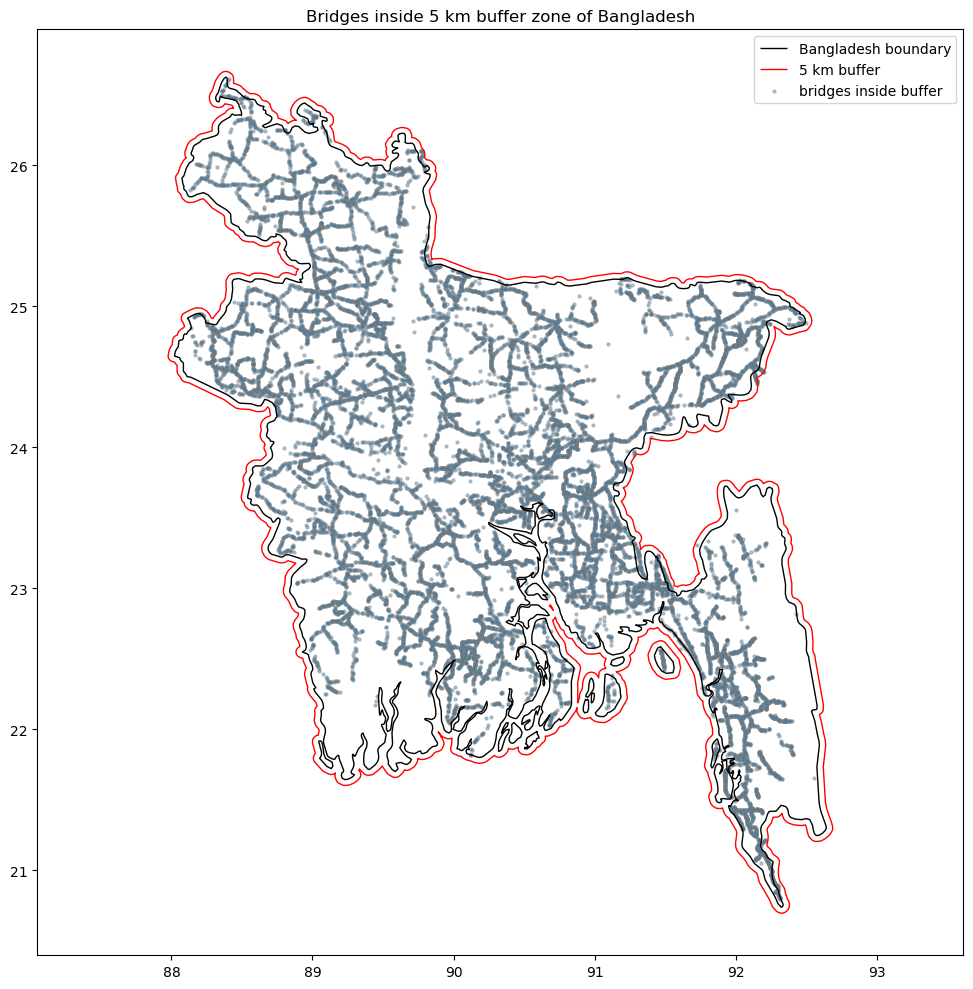

In [5]:
from shapely.geometry import Point
import geopandas as gpd

bangladesh_shape = gpd.read_file('data/shapefile_bangladesh')

# Create a buffer of 5 km (5000 meters) around the Bangladesh boundary
bangladesh_buffered = bangladesh_shape.to_crs(epsg=3857).buffer(5000).to_crs(epsg=4326)

# Create a function to filter datapoints that are outside the boundary of Bangladesh
def bridges_not_in_bangladesh(shapefile, df_bridges):

    # Convert bridge locations into a GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in zip(df_bridges["lon"], df_bridges["lat"])]
    gdf_bridges = gpd.GeoDataFrame(df_bridges, geometry=geometry, crs="EPSG:4326")

    # Filter bridges that are **outside** the buffered area
    bridges_outside = gdf_bridges[~gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]
    bridges_inside = gdf_bridges[gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]

    return gdf_bridges, bridges_outside, bridges_inside

# Filter the bridges that are outside the boundary of Bangladesh
gdf_bridges, bridges_outside, bridges_inside = bridges_not_in_bangladesh(bangladesh_buffered, df_brd_original)

# Display the bridges in 5 km buffer zone of Bangladesh
def plot_bridges_inside_buffer(bangladesh_shape, bangladesh_buffered, bridges_inside):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the Bangladesh boundary
    bangladesh_shape.boundary.plot(ax=ax, edgecolor='black', linewidth=1, label='Bangladesh boundary')
    bangladesh_buffered.boundary.plot(ax=ax, edgecolor='red', linewidth=1, label='5 km buffer')
    bridges_inside.plot(ax=ax, edgecolor='grey', facecolor=None, alpha=0.4, markersize=5, label='bridges inside buffer')

    # Set the aspect of the plot to be equal
    ax.legend()
    ax.set_aspect('equal')
    ax.set_aspect('equal')
    ax.set_box_aspect(1)
    ax.set_title('Bridges inside 5 km buffer zone of Bangladesh')

    fig.tight_layout()
    plt.savefig('Bridges_inside_5km_buffer.png', dpi=400)
    plt.show()

# Plot the bridges inside the buffer zone
plot_bridges_inside_buffer(bangladesh_shape, bangladesh_buffered, bridges_inside)

## `3. Fix swapped lat-lon values`

In [6]:
# Create a function to check and update the latitude and longitude of the bridges if lat lon are swapped
def check_and_update_lat_lon(df, gdf_bridges, shapefile):
    bridges_to_remove = set()

    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        if not (21 <= row['lat'] <= 26 and 88 <= row['lon'] <= 93):
            point = Point(row['lat'], row['lon'])
            if point.within(shapefile.unary_union):
                bridges_to_remove.add(row['name'])  # Use a set for fast lookups

    # Remove bridges directly in df
    df_cleaned = df[~df['name'].isin(bridges_to_remove)].copy()

    # Update lat/lon for bridges with swapped lat lon in gdf_bridges
    mask = gdf_bridges['name'].isin(bridges_to_remove)
    gdf_bridges.loc[mask, ['lat', 'lon']] = gdf_bridges.loc[mask, ['lon', 'lat']].values

    return df_cleaned, bridges_to_remove

# Call the function and remove bridges
updated_bridges_outside, bridges_lat_lon_swap = check_and_update_lat_lon(bridges_outside.copy(), gdf_bridges, bangladesh_buffered)

print(f"Removed bridges: {bridges_lat_lon_swap}")


C:\Users\groen\AppData\Local\Temp\ipykernel_344\86781385.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if point.within(shapefile.unary_union):


Removed bridges: {'KHASIRA BAILEY WITH STEEL DECK', 'TARA KHAI BRIDGE', 'EKOR CHAI BOX CULVERT', 'COUNDER NOLA BOX CULVERT', 'KOLKALI BOX CULVERT', 'KHASIRA BOX CULVERT', 'COUNDER NOLA BRIDGE', 'TARAKHAI BOX CULVERT', 'EKOR CHOL BOX CULVERT', 'MAJIDPUR TRUSS BRIDGE', 'BOMBOMI BRIDGE', 'KOKAL BOX CULVERT', 'HIJLA BOX CULVERT', 'GONGUR BAILEY WITH STEEL DECK', 'MAJIDEPUR BOX CULVERT'}


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


There were 15 bridges with swapped lat-lon coordinates


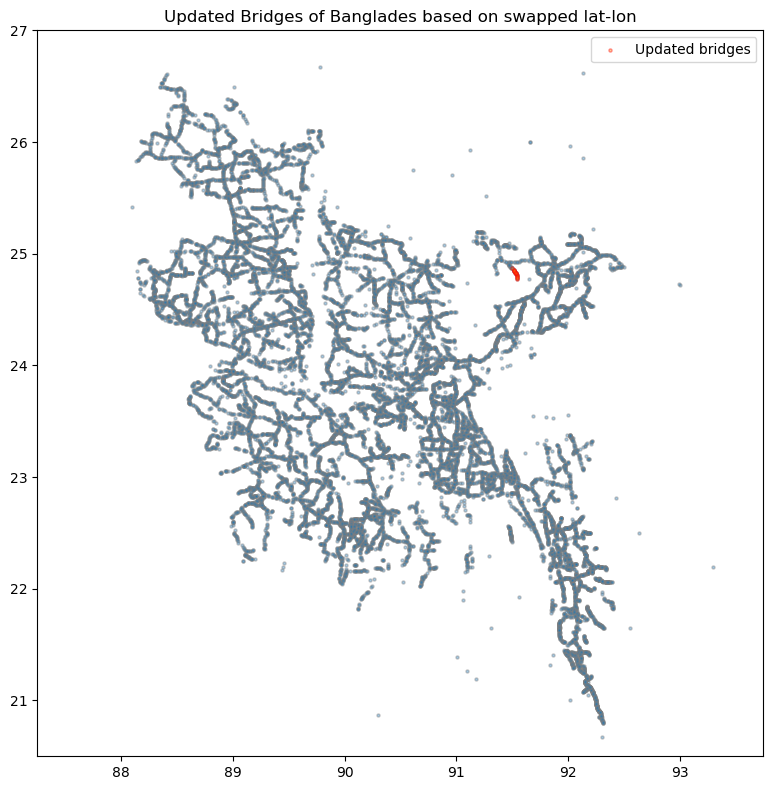

In [7]:
# Create plot to display the new bridges located in Bangladesh

def plot_bridges_in_bangladesh(df, df_to_highlight, title):
    # Create a figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Create a scatter plot for all the bridges around Bangladesh
    ax.scatter(df['lon'], df['lat'], s=5, edgecolor='grey', facecolor=None, alpha=0.4)

    # Create a scatter plot for the updated bridges
    ax.scatter(df_to_highlight['lon'], df_to_highlight['lat'], s=5, edgecolor='red', facecolor=None, alpha=0.4, label='Updated bridges')

    # Set the title, labels, limits and legends
    ax.set_xlim(88, 93)
    ax.set_ylim(20.5, 27)
    ax.set_aspect('equal')
    ax.set_box_aspect(1)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.savefig('images/swapped_lat_lon_bridges.png', dpi=400)
    plt.show()

# Plot the shapefile of Bangladesh
removed_bridges_df = gdf_bridges[gdf_bridges['name'].isin(bridges_lat_lon_swap)]
print(f'There were {len(removed_bridges_df)} bridges with swapped lat-lon coordinates')

plot_bridges_in_bangladesh(gdf_bridges, removed_bridges_df, title='Updated Bridges of Banglades based on swapped lat-lon')


## `4. Check for road present in road dataset`

In [8]:
# Checks if the bridges are on a road in the road dataset

def check_roads_present(df_bridges, df_roads):
    # Create a set to store the bridges that do not match
    bridges_not_matching = set()

    # Iterate through each row in the DataFrame
    for _, row in df_bridges.iterrows():
        # Check if the bridge's road is not in the road dataset
        if row['road'] not in df_roads['road'].values:
            bridges_not_matching.add(row['structureNr'])

    return bridges_not_matching

# Call the function to check for bridges that do not match
bridges_not_matching = check_roads_present(gdf_bridges.copy(), df_rd.copy())
# print(bridges_not_matching)

bridges_not_matching_df = gdf_bridges[gdf_bridges['structureNr'].isin(bridges_not_matching)]
print(f'Number of bridges on a road not matching the road dataset: {len(bridges_not_matching)}')

# Print the unqiue roads that are not in the road dataset, but are in the bridge dataset
print(bridges_not_matching_df['road'].unique())



Number of bridges on a road not matching the road dataset: 544
['R505' 'R680' 'R750' 'R856' 'Z1006' 'Z1090' 'Z1211' 'Z1463' 'Z1503'
 'Z1632' 'Z2022' 'Z2033' 'Z3614' 'Z5071' 'Z5073' 'Z5208' 'Z5458' 'Z5459'
 'Z5478' 'Z6801' 'Z6814' 'Z6815' 'Z1613' 'Z7048' 'Z7049' 'Z8711' 'Z8948'
 'Z1705']


In [9]:
def plot_the_bridges(df_on_road, df_not_on_road, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.scatter(df_on_road['lon'], df_on_road['lat'], s=5, edgecolor='grey', facecolor=None, alpha=0.4, label='Bridges on a Road')
    ax.scatter(df_not_on_road['lon'], df_not_on_road['lat'], s=5, edgecolor='red', facecolor=None, alpha=0.4, label='Bridges not on a Road')
    
    # Set the title, labels and legend
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()

    # Set the aspect of the plot to be equal
    ax.set_xlim(88, 93)
    ax.set_ylim(20.5, 27)
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig(f'images/{title}.png', dpi=400)
    plt.show()


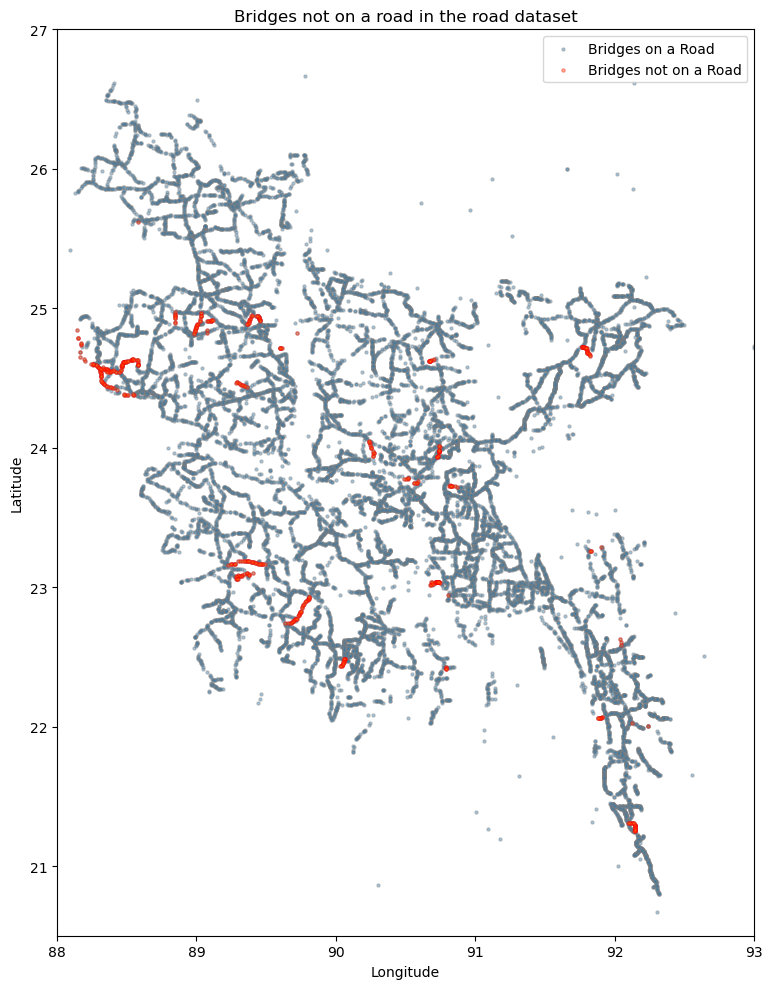

In [10]:
# Plot the bridges that are not on a road in the road dataset
bridges_matching_df = gdf_bridges[~gdf_bridges['road'].isin(bridges_not_matching)]

plot_the_bridges(bridges_matching_df, bridges_not_matching_df, title='Bridges not on a road in the road dataset')

## `5. Correct bridges that aren't on the correct road location`

For bridges that do have a corresponding road in the road dataset, but are located far away from the road, we try to interpolate their value based on the LRP distance

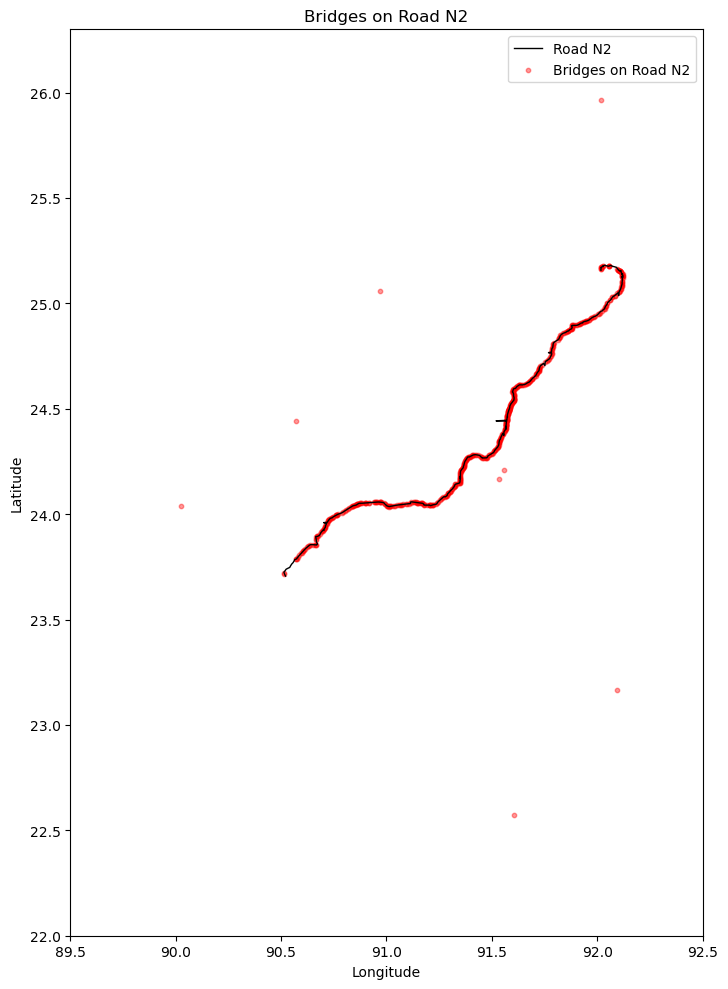

In [11]:
road = 'N2'

specific_road_index = df_rd[df_rd['road'] == road].index[0]
specific_road = df_rd.iloc[specific_road_index]

# Select every third value for 'LAT' and every third +1 value for 'LON'
df_rd_N1 = pd.DataFrame({
    'LRP': specific_road.iloc[1::3].values,   # Every third value
    'LAT': specific_road.iloc[2::3].values,   # Every third value
    'LON': specific_road.iloc[3::3].values   # Every third +1 value
})

df_rd_N1['LAT'] = df_rd_N1['LAT'].astype(float)
df_rd_N1['LON'] = df_rd_N1['LON'].astype(float)

# Bridges on the specific road
bridges_on_road = gdf_bridges[gdf_bridges['road'] == road]

# Create plot
def plot_spec_road_with_bridges(df_rd, bridges_on_road):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the road
    ax.plot(df_rd['LON'], df_rd['LAT'], color='black', linewidth=1, label=f'Road {road}')

    # plot the bridges
    ax.scatter(bridges_on_road['lon'], bridges_on_road['lat'], s=10, edgecolor='red', facecolor='red', alpha=0.4, label=f'Bridges on Road {road}')

    # Set the title, labels and legend
    ax.set_title(f'Bridges on Road {road}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()

    ax.set_xlim(89.5, 92.5)
    ax.set_ylim(22, 26.3)
    ax.set_aspect('equal')

    fig.tight_layout()
    plt.savefig('images/bridges_on_road_N2.png', dpi=400)
    plt.show()

plot_spec_road_with_bridges(df_rd_N1, bridges_on_road)

drainage_df = pd.read_csv('data/Roads_InfoAboutEachLRP.csv', sep=',', low_memory=False)
# display(drainage_df.head(5))

In [12]:
# Initialize the transformer once (faster than creating it inside the function)
TRANSFORMER = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def get_closest_distance(bridge_lat, bridge_lon, road_line):
    """Calculate the shortest distance from a bridge to the road."""
    bridge_x, bridge_y = TRANSFORMER.transform(bridge_lon, bridge_lat)
    bridge_point = Point(bridge_x, bridge_y)
    return bridge_point.distance(road_line)

def preprocess_roads(df_roads):
    """Precompute road geometry in a projected coordinate system (EPSG:3857)."""
    road_points = [TRANSFORMER.transform(lon, lat) for lon, lat in zip(df_roads['LON'], df_roads['LAT'])]
    
    # Ensure there are at least two points before creating a LineString
    if len(road_points) > 1:
        return LineString(road_points)
    else:
        return None  # Return None for invalid roads

def identify_bridges_far_from_road(df_bridges, df_roads, distance_threshold=250):
    """Identify bridges that are far from their respective roads."""
    
    # Filter bridges that have a matching road in df_roads
    df_bridges = df_bridges[df_bridges['road'].isin(df_roads['road'].values)]

    # Precompute road geometries
    road_geometries = {road: preprocess_roads(road_df) for road, road_df in df_roads.groupby("road")}

    # Set to store bridges far from the road
    bridges_far = set()

    # Process each bridge efficiently using .itertuples()
    for bridge in tqdm(df_bridges.itertuples(index=False), total=len(df_bridges), desc="Processing Bridges", unit="bridge"):
        if bridge.road in road_geometries:
            road_line = road_geometries[bridge.road]
            distance = get_closest_distance(bridge.lat, bridge.lon, road_line)

            # If distance is greater than threshold, add to set
            if distance > distance_threshold:
                bridges_far.add(bridge.structureNr)

    return bridges_far

# Call the optimized function
bridges_far = identify_bridges_far_from_road(gdf_bridges.copy(), df_rd_long.copy(), distance_threshold=500)


Processing Bridges:  23%|██▎       | 4710/20855 [00:00<00:00, 23567.86bridge/s]c:\Users\groen\miniconda3\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
Processing Bridges: 100%|██████████| 20855/20855 [00:00<00:00, 27549.55bridge/s]


In [13]:
bridges_far_from_road = gdf_bridges[gdf_bridges['structureNr'].isin(bridges_far)]

print(f'Number of bridges far from the road: {len(bridges_far)}')

Number of bridges far from the road: 1165


Illustrate for the N2

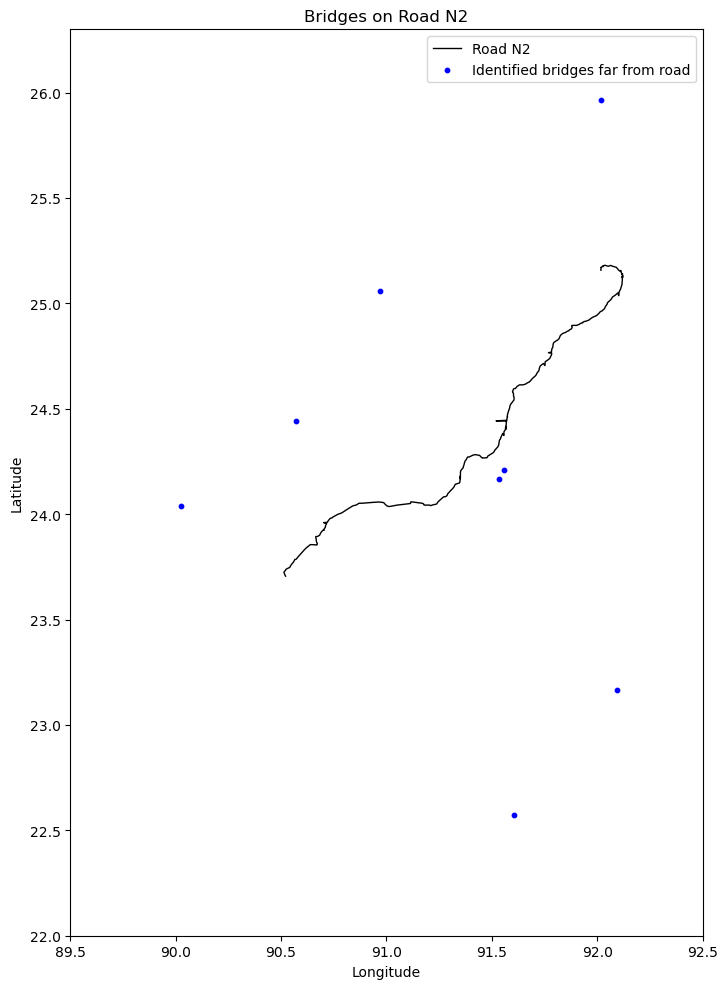

In [14]:
def plot_spec_road_with_bridges(df_rd, bridges_on_road):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the road
    ax.plot(df_rd['LON'], df_rd['LAT'], color='black', linewidth=1, label=f'Road {road}')

    # plot the bridges
    ax.scatter(bridges_on_road['lon'], bridges_on_road['lat'], s=10, edgecolor='blue', facecolor='blue', label=f'Identified bridges far from road')

    # Set the title, labels and legend
    ax.set_title(f'Bridges on Road {road}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.set_xlim(89.5, 92.5)
    ax.set_ylim(22, 26.3)
    ax.set_aspect('equal')

    ax.legend()
    fig.tight_layout()
    plt.savefig('images/bridges_far_from_road_N2.png', dpi=400)
    plt.show()

plot_spec_road_with_bridges(df_rd_N1, bridges_far_from_road[bridges_far_from_road['road'] == 'N2'])

In [ ]:
display(bridges_far_from_road[bridges_far_from_road['road'] == 'N2'])

display(drainage_df[drainage_df['road'] == 'N2'])

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,...,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,geometry
525,N2,64.333,RCC Girder Bridge,LRP064b,NARAYAN PUR RCC GIDER BRIDGE,11.60,A,103370,Dhaka (Katchpur)-Bhairab-Jagadishpur-Shaistaga...,64.333,...,1985.0,1.0,Dhaka,Dhaka,Narsingdi,Shibpur,24.439639,90.569250,bcs1,POINT (90.56925 24.43964)
660,N2,150.812,Box Culvert,LRP151b,ISLAMPUR,6.40,A,103589,Dhaka (Katchpur)-Bhairab-Jagadishpur-Shaistaga...,150.812,...,2003.0,3.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.166944,91.533556,bcs1,POINT (91.53356 24.16694)
675,N2,158.025,Box Culvert,LRP159a,SHOURATUL,7.90,A,103506,Dhaka (Katchpur)-Bhairab-Jagadishpur-Shaistaga...,158.025,...,2003.0,3.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.209694,91.558778,bcs1,POINT (91.55878 24.20969)
855,N2,246.910,Box Culvert,LRP247a,KHAN BAGAN,6.50,A,103778,Dhaka (Katchpur)-Bhairab-Jagadishpur-Shaistaga...,246.91,...,2000.0,1.0,Sylhet,Sylhet,Sylhet,Sylhet,25.963389,92.019083,bcs1,POINT (92.01908 25.96339)
892,N2,274.882,RCC Girder Bridge,LRP276a,ASUM BAZAR,36.70,A,103931,Dhaka (Katchpur)-Bhairab-Jagadishpur-Shaistaga...,274.882,...,2001.0,3.0,Sylhet,Sylhet,Sylhet,Sylhet,23.164556,92.096028,bcs1,POINT (92.09603 23.16456)
15571,N2,69.279,Box Culvert,LRP069d,RASHOMPUR,6.40,B,112551,Dhaka (Katchpur)-Bhairab-Jagadishpur-Shaistaga...,69.279,...,1984.0,2.0,Dhaka,Dhaka,Narsingdi,Shibpur,25.056806,90.969583,bcs1,POINT (90.96958 25.05681)
15596,N2,179.044,RCC Girder Bridge,LRP180a,Ratunpur -3 Bridge,14.00,B,120950,Dhaka (Katchpur)-Bhairab-Jagadishpur-Shaistaga...,179.044,...,NaN,NaN,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,22.570749,91.602833,road_precise,POINT (91.60283 22.57075)
20332,N2,75.778,RCC Girder Bridge,LRP075b,SUNARAMPUR BRIGE,79.75,D,103345,Dhaka (Katchpur)-Bhairab-Jagadishpur-Shaistaga...,75.778,...,1978.0,3.0,Comilla,Comilla,Brahmanbaria,Brahmanbaria,24.037917,90.024278,bcs1,POINT (90.02428 24.03792)


,road,chainage,lrp,lat,lon,type,name
2380,N2,0.000,LRPS,23.705917,90.521444,Others,Road Start from N1 at Katchpur
2381,N2,0.166,LRP001,23.706889,90.520472,KmPost,Sylhet 230 km
2382,N2,1.166,LRP002,23.715139,90.516833,KmPost,Sylhet 229 km
2383,N2,1.536,LRP002a,23.718277,90.515694,Bridge,Bridge start
2384,N2,1.576,LRP002b,23.718610,90.515556,Bridge,Bridge end
...,...,...,...,...,...,...,...
3272,N2,285.938,LRP287,25.162889,92.017110,KmPost,Jaflong 1 km
3273,N2,286.022,LRP287a,25.161333,92.017277,Bridge,Bridge start
3274,N2,286.060,LRP287b,25.160972,92.017333,Bridge,Bridge end
3275,N2,286.260,LRP287c,25.159750,92.017472,Culvert,Box culvert


In [ ]:
# Create a function to interpolate the location of a bridge based on the chainage of the two closest points
def interpolate_location(bridge, lower, higher):
    """Interpolate latitude and longitude based on chainage values."""
    if lower.empty or higher.empty:
        return None  # Return None if no valid interpolation points exist

    # Extract relevant values
    chainage_lower, lat_lower, lon_lower = lower.iloc[0][['chainage', 'lat', 'lon']]
    chainage_higher, lat_higher, lon_higher = higher.iloc[0][['chainage', 'lat', 'lon']]
    chainage_bridge = bridge['chainage']

    # Compute interpolation factor
    factor = (chainage_bridge - chainage_lower) / (chainage_higher - chainage_lower)

    # Linearly interpolate latitude and longitude
    interpolated_lat = lat_lower + factor * (lat_higher - lat_lower)
    interpolated_lon = lon_lower + factor * (lon_higher - lon_lower)

    return interpolated_lon, interpolated_lat

def interpolate_bridges_based_on_chainage(df_bridges, drainage_df):
    """Interpolate new bridge locations based on nearest chainage points."""
    interpolated_bridges = {}

    for _, bridge in df_bridges.iterrows():
        road = bridge['road']
        chainage = bridge['chainage']

        # Select drainage points matching the road
        road_drainage = drainage_df[drainage_df['road'] == road]

        # Find closest points (lower and higher chainage)
        closest_point_lower = road_drainage[road_drainage['chainage'] < chainage].nlargest(1, 'chainage')
        closest_point_higher = road_drainage[road_drainage['chainage'] > chainage].nsmallest(1, 'chainage')

        # Interpolate new location
        new_location = interpolate_location(bridge, closest_point_lower, closest_point_higher)

        if new_location:
            interpolated_bridges[bridge['structureNr']] = new_location

    # Convert results to DataFrame
    interpolated_bridges_df = pd.DataFrame.from_dict(interpolated_bridges, orient='index', columns=['lon', 'lat'])

    return interpolated_bridges_df

# Apply function for testing with the N2
# test_bridges_N2 = bridges_far_from_road[bridges_far_from_road['road'] == 'N2']
# interpolated_bridges = interpolate_bridges_based_on_chainage(test_bridges_N2, drainage_df)

interpolated_bridges = interpolate_bridges_based_on_chainage(bridges_far_from_road, drainage_df)


# Change the lon and lat of the bridges in the original DataFrame
for structureNr, row in interpolated_bridges.iterrows():
    gdf_bridges.loc[gdf_bridges['structureNr'] == structureNr, ['lon', 'lat']] = row['lon'], row['lat']



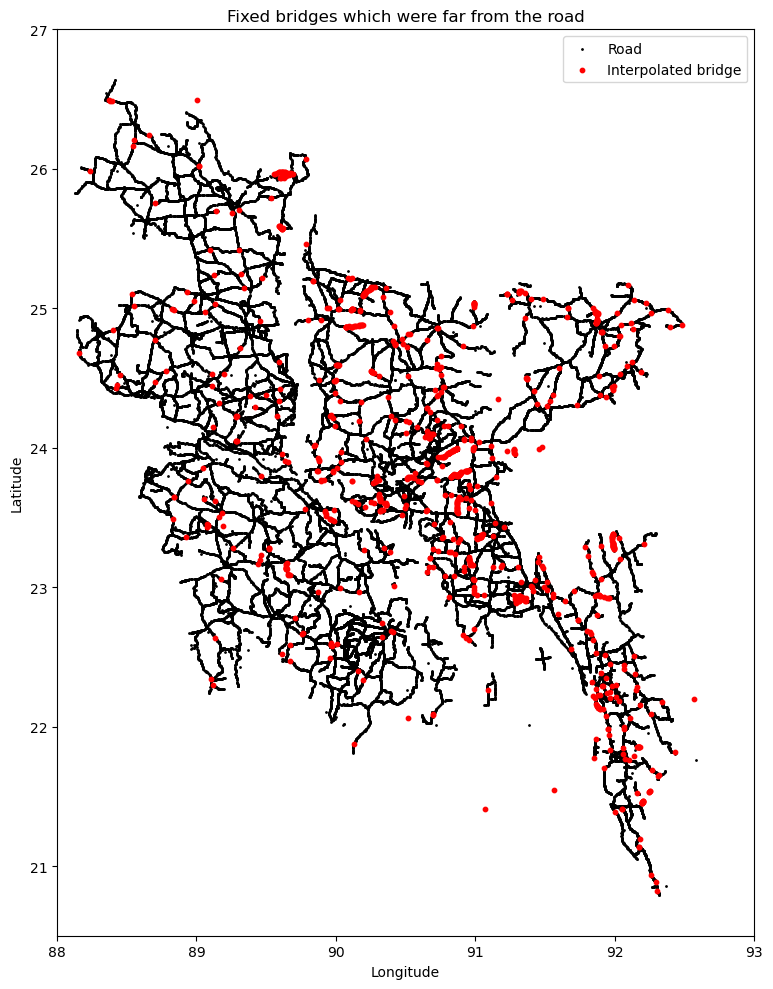

In [17]:
def plot_spec_road_with_bridges(df_rd, bridges_far_from_road, new_loc_bridges):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the road
    ax.scatter(df_rd['LON'], df_rd['LAT'], color='black', s=1, label=f'Road')

    # Plot the new locations
    ax.scatter(new_loc_bridges['lon'], new_loc_bridges['lat'], s=10, edgecolor='red', facecolor='red', label=f'Interpolated bridge')

    # Set the title, labels and legend
    ax.set_title(f'Fixed bridges which were far from the road')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.set_xlim(88, 93)
    ax.set_ylim(20.5, 27)
    ax.set_aspect('equal')

    ax.legend()
    fig.tight_layout()
    plt.savefig('images/bridges_far_from_road_fixed.png', dpi=400)
    plt.show()

# For testing with the N2
# plot_spec_road_with_bridges(df_rd_N1, test_bridges, interpolated_bridges)

plot_spec_road_with_bridges(df_rd_long, bridges_far_from_road, interpolated_bridges)

## Transform the bridges dataset back to the format working in Java

In [34]:
gdf_bridges.to_csv('data/BMMS_overview_new.xlsx', index=False)

# Code below is not working

In [18]:
# from shapely.geometry import LineString, Point
# from shapely.ops import nearest_points
# # from geopy.distance import geodesic
# import pyproj

# # Create a function to calculate the shortest distance from a bridge to the road
# # def get_closest_distance(bridge, df_road):
# #     """
# #     Calculate the shortest distance from a single bridge to the road.
# #     """
# #     road_nr = bridge['road']
# #     df_road = df_road[df_road['road'] == road_nr]

# #     # Convert road points to a LineString
# #     road_line = LineString(zip(df_road['LON'], df_road['LAT']))

# #     # Create a Point for the bridge location
# #     bridge_point = Point(bridge['lon'], bridge['lat'])

# #     # Calculate and return the shortest distance
# #     return bridge_point.distance(road_line)

# def get_closest_distance(bridge, df_roads):
#     # Convert bridge and road points to a projected coordinate system (UTM or another local CRS)
#     transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    
#     # Transform bridge coordinates
#     bridge_x, bridge_y = transformer.transform(bridge['lon'], bridge['lat'])
#     bridge_point = Point(bridge_x, bridge_y)

#     # Convert road points into a LineString
#     road_points = [transformer.transform(lon, lat) for lon, lat in zip(df_roads['LON'], df_roads['LAT'])]
#     road_line = LineString(road_points)

#     # Return the shortest distance in meters
#     return bridge_point.distance(road_line)

# # Example usage:
# single_bridge = gdf_bridges.iloc[1]  # Select one bridge
# distance = get_closest_distance(single_bridge, df_rd_long)
# print(f"Shortest distance to a point on the road: {distance} m")

In [19]:
# def get_closest_distance(bridge, df_roads):
#     # Convert bridge and road points to a projected coordinate system (UTM or another local CRS)
#     transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    
#     # Transform bridge coordinates
#     bridge_x, bridge_y = transformer.transform(bridge['lon'], bridge['lat'])
#     bridge_point = Point(bridge_x, bridge_y)

#     # Convert road points into a LineString
#     road_points = [transformer.transform(lon, lat) for lon, lat in zip(df_roads['LON'], df_roads['LAT'])]
#     road_line = LineString(road_points)

#     # Return the shortest distance in meters
#     return bridge_point.distance(road_line)

# # Bridges with a road in the road dataset
# bridges_with_road = gdf_bridges[gdf_bridges['road'].isin(df_roads_cleaned_chainage['road'].values)]

# # Identify bridges that are located far from the road
# def identify_bridges_far_from_road(df_bridges, df_roads, distance_threshold=500):
#     # Create a set to store the bridges that are far from the road
#     bridges_far = set()

#     # Iterate through each row in the DataFrame
#     # for _, bridge in df_bridges.iterrows():
#     for _, bridge in tqdm(df_bridges.iterrows(), total=len(df_bridges), desc="Processing Bridges", unit="bridge"):
#         # Get the road that the bridge is on
#         road = df_roads[df_roads['road'] == bridge['road']]

#         # Calculate the distance between the bridge and the road
#         # distance = road.apply(lambda row: haversine_distance(bridge['lat'], bridge['lon'], row['LAT'], row['LON']), axis=1)
#         distance = get_closest_distance(bridge, df_roads)

#         # Check if the minimum distance is greater than the threshold
#         if distance > distance_threshold:
#             bridges_far.add(bridge['structureNr'])

#     return bridges_far

# # Call the function to identify bridges that are far from the road
# bridges_far = identify_bridges_far_from_road(bridges_with_road.copy(), df_rd_long.copy(), distance_threshold=100)

In [20]:
# # Check if the LRPName and road of the bridges match with the LRPName and road of the road dataset

# def check_bridge_road_match(df_bridges, df_rd):
#     # Create a set to store the bridges that do not match
#     bridges_not_matching = set()

#     # Iterate through each row in the DataFrame
#     for _, row in df_bridges.iterrows():
#         # Check if the bridge's LRPName and road are not in the road dataset
#         if row['road'] not in df_rd['road'].values:
#             bridges_not_matching.add(row['structureNr'])

#     return bridges_not_matching

# # Call the function to check for bridges that do not match
# bridges_not_matching = check_bridge_road_match(gdf_bridges.copy(), df_rd.copy())

# print(bridges_not_matching)
# print(len(bridges_not_matching))

In [21]:
# # Function to find the road points before and after the bridge
# def find_road_points(df, chainage):
#     before = df[df['chainage'] <= chainage].sort_values('chainage', ascending=False)
#     after = df[df['chainage'] >= chainage].sort_values('chainage', ascending=True)
    
#     if before.empty or after.empty:
#         return None, None  # Handle missing cases
    
#     return before.iloc[0], after.iloc[0]  # Closest before/after points


In [22]:
# # Function to update bridge coordinates if necessary
# def update_bridge_coordinates(df_bridges, df_road):
#     for idx, bridge in df_bridges.iterrows():
#         road_points = df_road[df_road['road'] == bridge['road']]
        
#         if not road_points.empty:
#             before, after = find_road_points(road_points, bridge['chainage'])
#             if before is None or after is None:
#                 continue  # Skip if no valid points found
            
#             # Skip adjustment if the bridge is already within the correct range
#             if before['chainage'] <= bridge['chainage'] <= after['chainage']:
#                 continue 

#             # Compute segment length
#             segment_dist = np.sqrt((before['lat'] - after['lat'])**2 + (before['lon'] - after['lon'])**2)
#             threshold = max(1.5 * segment_dist, 0.001)  # Ensure reasonable threshold
            
#             # Compute distances to the bridge
#             distance_before = np.sqrt((before['lat'] - bridge['lat'])**2 + (before['lon'] - bridge['lon'])**2)
#             distance_after = np.sqrt((after['lat'] - bridge['lat'])**2 + (after['lon'] - bridge['lon'])**2)
            
#             # If bridge is too far, reposition it
#             if distance_before > threshold or distance_after > threshold:
#                 df_bridges.at[idx, 'lat'] = (before['lat'] + after['lat']) / 2
#                 df_bridges.at[idx, 'lon'] = (before['lon'] + after['lon']) / 2

#     return df_bridges

# # Update the bridge coordinates
# updated_bridges_chainage = update_bridge_coordinates(gdf_bridges.copy(), df_roads_cleaned_chainage.copy())

# # Display results
# updated_bridges_chainage.head()

## Check for min / sec reversal


In [23]:
# # Function to extract LRP, LAT, and LON for each road
# def extract_lrps(df_rd):
#     all_roads = []
    
#     for i in range(len(df_rd)):  # Loop through all rows (roads)
#         row = df_rd.iloc[i]

#         # print(row.iloc[0])

#         # Extract every third value for LRP, LAT, and LON
#         df_rd_long = pd.DataFrame({
#             'road': row.iloc[0],
#             'LRP': row.iloc[1::3].values,
#             'LAT': row.iloc[2::3].astype(float).values,
#             'LON': row.iloc[3::3].astype(float).values
#         })
        
#         # df_rd_N6['Road_ID'] = i  # Add road number 
#         all_roads.append(df_rd_long)  # Append results

#     return pd.concat(all_roads, ignore_index=True)  # Merge all road data

# df_rd_long = extract_lrps(df_rd)

# # Remove rows with nan values for lrp, lat and lon
# df_rd_long = df_rd_long.dropna(subset=['LRP', 'LAT', 'LON'])

# df_rd_long

In [24]:
# def decdeg2dms(dd):
#    is_positive = dd >= 0
#    dd = abs(dd)
#    minutes,seconds = divmod(dd*3600,60)
#    degrees,minutes = divmod(minutes,60)
#    degrees = degrees if is_positive else -degrees
#    return (degrees,minutes,seconds)

# print(decdeg2dms(21.924028))

In [25]:
# from shapely.geometry import LineString, Point
# from shapely.ops import nearest_points

# # Create a function to calculate the shortest distance from a bridge to the road
# def get_closest_distance(bridge, df_road):
#     """
#     Calculate the shortest distance from a single bridge to the road.
#     """
#     road_nr = bridge['road']
#     df_road = df_road[df_road['road'] == road_nr]

#     # Convert road points to a LineString
#     road_line = LineString(zip(df_road['LON'], df_road['LAT']))

#     # Create a Point for the bridge location
#     bridge_point = Point(bridge['lon'], bridge['lat'])

#     # Calculate and return the shortest distance
#     return bridge_point.distance(road_line)

# # Example usage:
# single_bridge = gdf_bridges.iloc[0]  # Select one bridge
# distance = get_closest_distance(single_bridge, df_rd_long)
# print(f"Shortest distance to a point on the road: {distance}")

In [26]:
# def dms2dec(degrees, minutes, seconds):
#     """Convert degrees, minutes, and seconds to decimal degrees."""
#     return degrees + (minutes / 60) + (seconds / 3600)


In [27]:
# from tqdm import tqdm  # For progress bar
# from shapely.geometry import Point

# def check_for_min_sec_mistakes(df_bridges, df_roads):
#     # Create a set to store the bridges that have better swapped locations
#     bridges_with_better_swapped_locations = set()
#     new_location_swapped_bridges = []

#     # Iterate through each row in the bridges DataFrame with tqdm progress bar
#     for _, row in tqdm(df_bridges.iterrows(), total=len(df_bridges), desc="Checking Bridges", unit="bridge"):
#         # Original coordinates
#         original_lat = row['lat']
#         original_lon = row['lon']

#         # Convert to degrees, minutes, and seconds
#         lat_deg, lat_min, lat_sec = decdeg2dms(original_lat)
#         lon_deg, lon_min, lon_sec = decdeg2dms(original_lon)

#         # Calculate the original distance to the road
#         original_distance = get_closest_distance(row, df_roads)

#         # Swap minutes and seconds
#         swapped_lat = dms2dec(lat_deg, lat_sec, lat_min)  # Swapped min and sec
#         swapped_lon = dms2dec(lon_deg, lon_sec, lon_min)  # Swapped min and sec

#         # Create a temporary row with swapped coordinates
#         swapped_row = row.to_dict()
#         swapped_row['lat'] = swapped_lat
#         swapped_row['lon'] = swapped_lon

#         # Calculate the new distance with swapped values
#         swapped_distance = get_closest_distance(swapped_row, df_roads)

#         # If swapping results in a shorter distance, mark this bridge
#         if swapped_distance < original_distance:
#             print(swapped_distance)
#             if swapped_distance <= 0.1:
#                 bridges_with_better_swapped_locations.add(row['structureNr'])
#                 new_location_swapped_bridges.append(swapped_row)

#     df_new_locations = pd.DataFrame(new_location_swapped_bridges)

#     return bridges_with_better_swapped_locations, df_new_locations

# # Call the function
# bridges_with_better_swapped_locations, df_new_locations = check_for_min_sec_mistakes(gdf_bridges.copy(), df_rd_long.copy())



In [28]:
# gdf_old_bridges = gdf_bridges[gdf_bridges['structureNr'].isin(bridges_with_better_swapped_locations)]

In [29]:
# # Display results
# # bridges_with_better_swapped_locations_df = gdf_bridges[gdf_bridges['structureNr'].isin(bridges_with_better_swapped_locations)]
# def plot_the_bridges(df_old, df_new, df_all, df_rd, title):
#     fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#     # ax.plot(df_rd_long['LON'], df_rd_long['LAT'], color='black', linewidth=1, label='Roads')

#     try:
#         roads = df_rd['road'].unique()
#         num_roads = len(roads)
#         for idx, (road, group) in enumerate(df_rd.groupby('road')):
#             plt.plot(group['LON'], group['LAT'], 'o-', markersize=1, color='black')#, color=color)
#     except:
#         group = df_rd
#         plt.plot(group['LON'], group['LAT'], 'o-', markersize=1)



#     ax.scatter(df_old['lon'], df_old['lat'], s=5, edgecolor='red', facecolor='red', alpha=0.8, label='Old Bridges with swapped lat/lon')
#     ax.scatter(df_new['lon'], df_new['lat'], s=5, edgecolor='blue', facecolor='blue', alpha=1, label='new bridges with swapped lat/lon')
#     ax.scatter(df_all['lon'], df_all['lat'], s=5, edgecolor='grey', facecolor=None, alpha=0.4, label='All (old) bridges')

#     # Set the title, labels and legend
#     ax.set_title(title)
#     ax.set_xlabel('Longitude')
#     ax.set_ylabel('Latitude')
#     ax.legend()

#     # Set the aspect of the plot to be equal
#     ax.set_xlim(88, 93)
#     ax.set_ylim(20.5, 27)
#     ax.set_aspect('equal')

#     plt.tight_layout()
#     plt.show()


# plot_the_bridges(gdf_old_bridges, df_new_locations, gdf_bridges, df_rd_long, title='Bridges with better swapped locations')

In [30]:
# gdf_old_bridges[gdf_old_bridges['road'] == 'Z5624']

In [31]:
# df_new_locations[df_new_locations['road'] == 'Z5624']

In [32]:
# def plot_specific_road(df_rd, specific_road, df_new_locations):
#     fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#     try:
#         roads = df_rd['road'].unique()
#         num_roads = len(roads)
#         for idx, (road, group) in enumerate(df_rd.groupby('road')):
#             plt.plot(group['LON'], group['LAT'], 'o-', markersize=1, color='black')#, color=color)
#     except:
#         group = df_rd
#         plt.plot(group['LON'], group['LAT'], 'o-', markersize=1)

#     ax.scatter(specific_road['LON'], specific_road['LAT'], s=5, edgecolor='red', facecolor='red', alpha=1, label='Specific Road')
#     ax.set_title('Specific Road')

#     road = df_new_locations[df_new_locations['road'] == 'Z5624']
#     ax.scatter(road['lon'], road['lat'], s=5, edgecolor='blue', facecolor='blue', alpha=1, label='New Bridges with swapped lat/lon')

#     plt.show()

# # Plot the specific road
# specific_road = df_rd_long[df_rd_long['road'] == 'Z5624']
# plot_specific_road(df_rd_long, specific_road, df_new_locations)
     